<a href="https://colab.research.google.com/github/Nina-Konovalova/Bayesian-optimization/blob/main/Landscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install GPy gpyopt

     |████████████████████████████████| 1.0MB 6.8MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp37-cp37m-linux_x86_64.whl size=2626975 sha256=cd4016509fab6a987bd84aae683849eed5871194a0775e9dc0b538535c781627
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for gpyopt: filename=GPyOpt-1.2.6-cp37-none-any.whl size=83623 sha256=cc14d8386e78bd97b94e9707f885b20c37514e4467093bf9a36835185cdaa212
  Stored in directory: /root/.cache/pip/wheels/b2/00/69/cfa967a125cf25e66f644be6193ad6f0edf231147879ad714f
  Created wheel for paramz: filename=paramz-0.9.5-cp37-none-any.whl size=102552 sha256=b4d9ea401446561ef655d87a374a7e3eb894a0e3e2b303a12e22380eabb8d6af
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy gpyopt paramz


In [2]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from numpy.random import seed
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from numba import njit
seed(12354)

Populating the interactive namespace from numpy and matplotlib


## True value

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/My Drive/SCM

/content/drive/My Drive/SCM


In [5]:
# X real - free energy landscape 
dat = pd.read_csv('try_to_estim_1.txt', sep='\t',skiprows=[0,1], header=None)
X_real = np.array(dat[:][1])

# Y real
# Y_pos_real - probability for translocation pos
# Y_neg_real - probability for translocation neg
# rate - num of pos transloctions/ num of all translocations 
dat2 = pd.read_csv('try_to_estim_res1.txt', sep=' ',skiprows=[0,1], header=None)
dat2.drop(dat2.columns[0], axis = 1, inplace = True)
Y_pos_real = np.array(dat2[:][1])
Y_neg_real = np.array(dat2[:][2])

# Rate real
dat2 = pd.read_csv('try_to_estim_res1.txt', sep=' ',nrows=1, header=None)
rate_real = float(dat2[11])


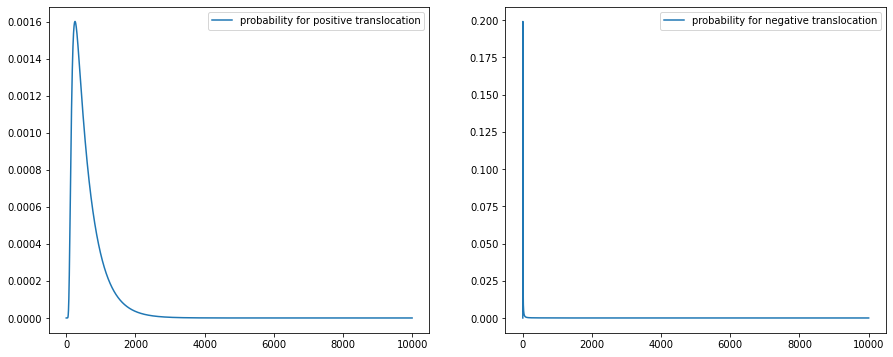

In [6]:
# plots for probability distributions
# 1) successful translocation
# 2) unsuccessful translocation

fig, axes = plt.subplots(1, 2)
axes[0].plot(Y_pos_real, label = 'probability for positive translocation')
axes[0].legend()
axes[1].plot(Y_neg_real, label = 'probability for negative translocation')
axes[1].legend()

fig.set_figwidth(15)    #  ширина и
fig.set_figheight(6)  

plt.show()

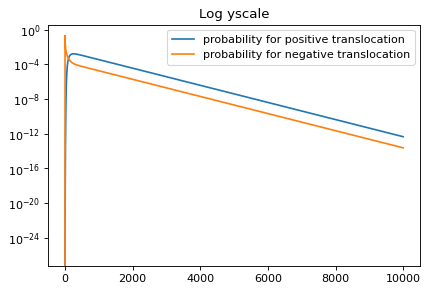

In [ ]:
# the same plots but in log scale

plt.figure(dpi = 80)
plt.plot(Y_pos_real, label = 'probability for positive translocation')
plt.legend()

plt.plot(Y_neg_real, label = 'probability for negative translocation')
plt.legend()

plt.yscale('log')
plt.title('Log yscale')
plt.show()

## Usual polynomial approximation

In [ ]:


# parameterizing real value
poly = Pipeline([('poly', PolynomialFeatures(degree=4)), ('linear', LinearRegression(fit_intercept=False))])
a = np.arange (51)
#b = X_try
b = X_real
poly.fit(a.reshape(-1,1), b)
b_pred = poly.predict(a.reshape(-1,1))
X_parametr_real = np.array(poly.named_steps['linear'].coef_)


In [ ]:
# Real input X ad parametrized with polynomial function

plt.figure(dpi = 80)
plt.plot(b_pred,'go--', linewidth=4, markersize=2, color = 'red', label = 'fitted by pol')
plt.plot(X_real, label = 'real X', )
plt.legend()

NameError: ignored

<Figure size 480x320 with 0 Axes>

## Chebyshev polynomial approximation

$
- T_{0}(x)=1 \\
- T_{1}(x)=x\;\\
- T_{2}(x)=2x^{2}-1\;\\
- T_{3}(x)=4x^{3}-3x\;\\
- T_{4}(x)=8x^{4}-8x^{2}+1\;\\
- T_{5}(x)=16x^{5}-20x^{3}+5x\;\\
- T_{6}(x)=32x^{6}-48x^{4}+18x^{2}-1\;\\
- T_{7}(x)=64x^{7}-112x^{5}+56x^{3}-7x\;\\
- T_{8}(x)=128x^{8}-256x^{6}+160x^{4}-32x^{2}+1\;$

$$p(x) = c_0 + c_1 * T_1(x) + ... + c_n * T_n(x)$$


In [16]:
import numpy.polynomial.chebyshev as cheb
p = cheb.Chebyshev.fit(np.arange(51),X_real, 5, window=[0,51])

In [ ]:
p

Chebyshev([-9.41786261e-02, -8.34339227e-04, -1.31702354e-03, -1.56697191e-05,
        6.66613410e-07, -3.82400213e-09], domain=[ 0., 50.], window=[ 0., 51.])

In [17]:
X_parametr_real = p.coef

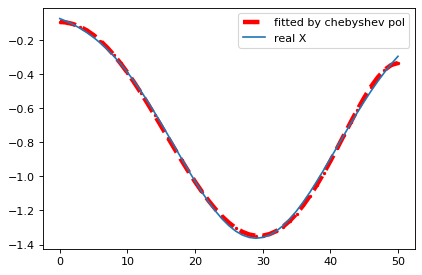

In [18]:
xx, yy = p.linspace(n=51)
plt.figure(dpi = 80)
plt.plot(xx, yy,'go--', linewidth=4, markersize=2, color = 'red', label = 'fitted by chebyshev pol')
plt.plot(np.arange(51),X_real,label = 'real X')

plt.legend()

## Hermition polynoms approximation

In [19]:
import numpy.polynomial.hermite as herm
h =herm.Hermite.fit(np.arange(51),X_real, 5, window=[0,51])

In [20]:
h

Hermite([-9.41766262e-02, -4.40741112e-04, -6.55845314e-04, -7.86353956e-06,
        3.33306705e-07, -1.91200107e-09], domain=[ 0., 50.], window=[ 0., 51.])

In [21]:
X_parametr_real = h.coef

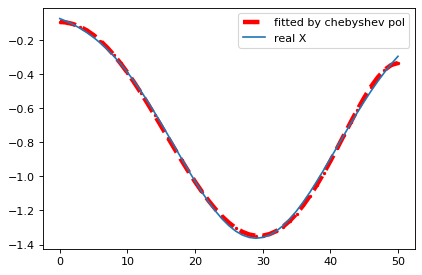

In [22]:
xx, yy = p.linspace(n=51)
plt.figure(dpi = 80)
plt.plot(xx, yy,'go--', linewidth=4, markersize=2, color = 'red', label = 'fitted by chebyshev pol')
plt.plot(np.arange(51),X_real,label = 'real X')

plt.legend()

## Another polynomials (doesn't look really better choice)
 - 

In [ ]:
#https://numpy.org/doc/stable/reference/routines.polynomials.laguerre.html
import numpy.polynomial.laguerre as lag
la = lag.Laguerre.fit(np.arange(51),X_real, 5, window=[0,51])

# https://numpy.org/doc/stable/reference/generated/numpy.polynomial.hermite_e.HermiteE.html#numpy.polynomial.hermite_e.HermiteE
import numpy.polynomial.hermite_e as herm
he =herm.HermiteE.fit(np.arange(51),X_real, 5, window=[0,51])

#https://numpy.org/doc/stable/reference/routines.polynomials.legendre.html
import numpy.polynomial.legendre as leg
le = leg.Legendre.fit(np.arange(51),X_real, 5, window=[0,51])

## Initial data

Parametrizing initial distributions (polynomial of 4 degree) - 600 initial data

In [ ]:
import pandas as pd
X = pd.read_csv('X for save').set_index('Unnamed: 0')
import numpy as np
X = np.array(X)
X_parametr_pol = np.zeros([X.shape[0], 5])
for i in range (X.shape[0]):
    poly = Pipeline([('poly', PolynomialFeatures(degree=4)), ('linear', LinearRegression(fit_intercept=False))])
    a = np.arange (51)
    b = X[i]
    #plt.plot(a,b)
    poly.fit(a.reshape(-1,1), b)
    b_pred = poly.predict(a.reshape(-1,1))
    X_parametr_pol[i] = np.array(poly.named_steps['linear'].coef_)

### Parametrizing initial distributions (by $\textbf{Chebyshev polynomial}$ of 4 degree) - 600 initial data

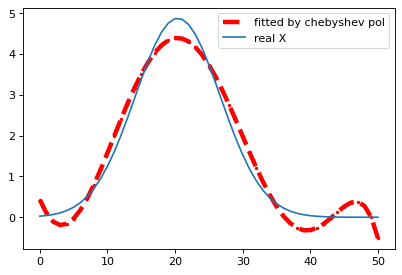

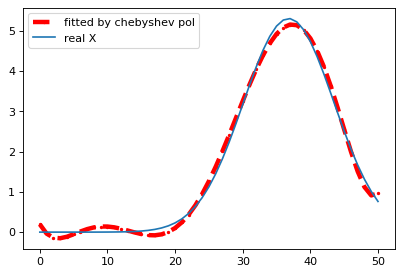

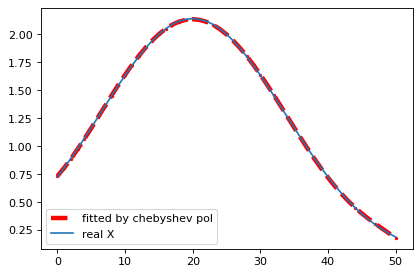

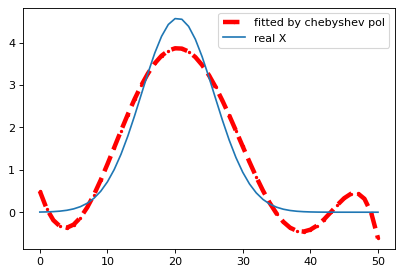

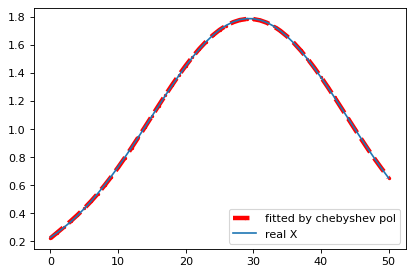

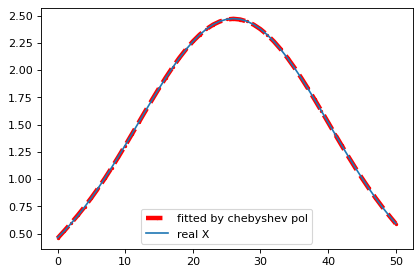

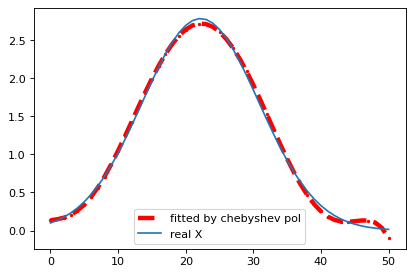

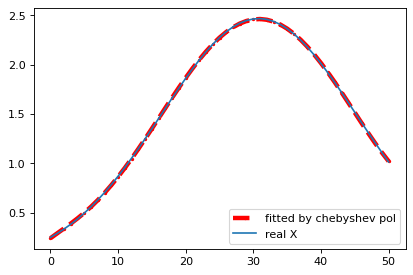

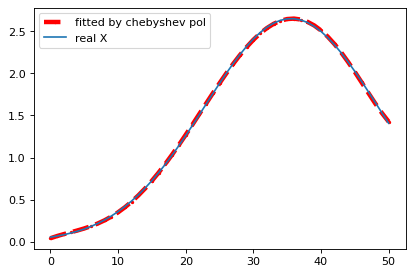

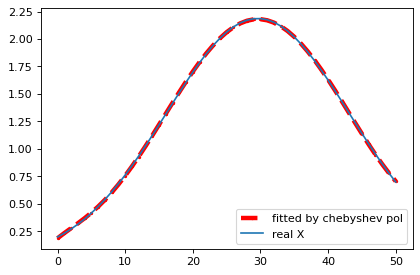

In [26]:
import pandas as pd
X = pd.read_csv('X for save').set_index('Unnamed: 0')
import numpy as np
X = np.array(X)
X_parametr_pol = np.zeros([X.shape[0], 7])
for i in range (X.shape[0]):
    p = cheb.Chebyshev.fit(np.arange(51),X[i], 6, window=[0,51])
    X_parametr_pol[i] = p.coef
    if i < 10 :
      xx, yy = p.linspace(n=51)
      plt.figure(dpi = 80)
      plt.plot(xx, yy,'go--', linewidth=4, markersize=2, color = 'red', label = 'fitted by chebyshev pol')
      plt.plot(np.arange(51),X[i],label = 'real X')

      plt.legend()


### Parametrizing initial distributions (by $\textbf{hermitian polynomial}$ of 4 degree) - 600 initial data

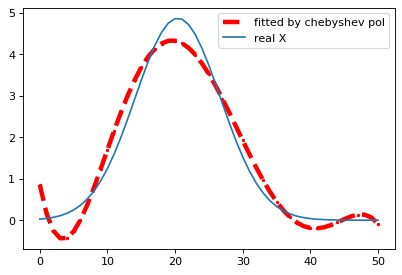

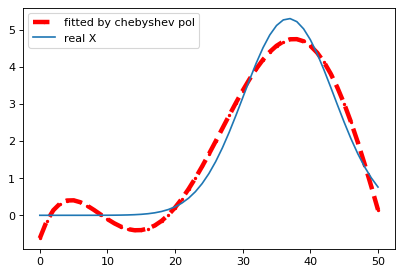

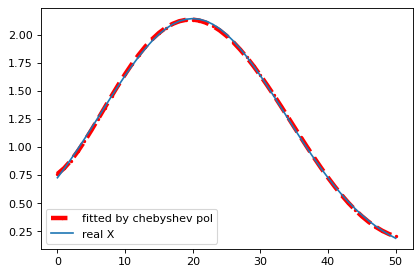

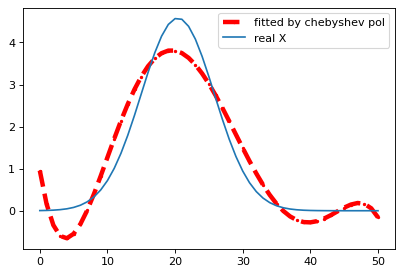

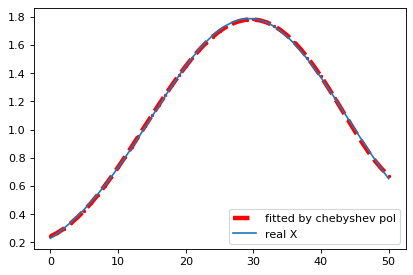

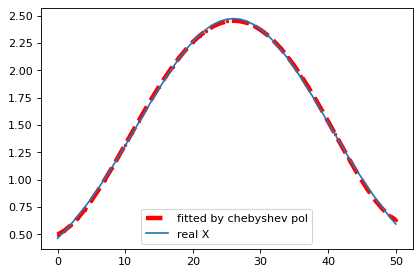

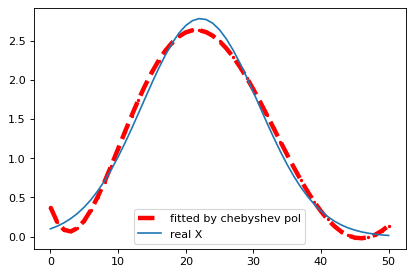

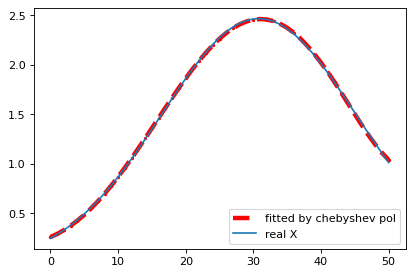

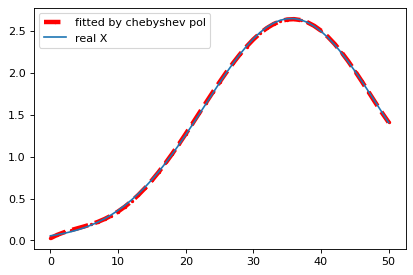

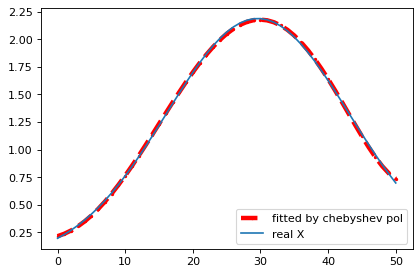

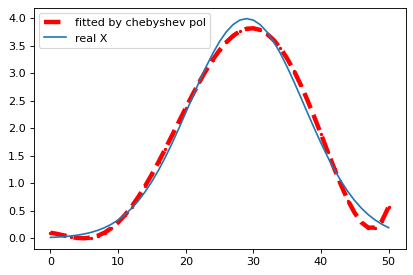

In [36]:
import pandas as pd
X = pd.read_csv('X for save').set_index('Unnamed: 0')
import numpy as np
X = np.array(X)
X_parametr_pol = np.zeros([X.shape[0], 6])
for i in range (X.shape[0]):
    h = herm.Hermite.fit(np.arange(51),X[i], 5, window=[0,51])
    X_parametr_pol[i] = h.coef
    if i <= 10:
      xx, yy = h.linspace(n=51)
      plt.figure(dpi = 80)
      plt.plot(xx, yy,'go--', linewidth=4, markersize=2, color = 'red', label = 'fitted by chebyshev pol')
      plt.plot(np.arange(51),X[i],label = 'real X')

      plt.legend()

### the next 2 cells havn't been used in the progrmam yet but may be in the future 

In [ ]:
Y_pos_new = pd.read_csv('y_pos for save').set_index('Unnamed: 0')
Y_neg_new = pd.read_csv('y_neg for save').set_index('Unnamed: 0')
rate = pd.read_csv('rate for save').set_index('Unnamed: 0')

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import numpy as np
diff_pos = np.zeros(Y_pos_new.shape[0])
diff_neg = np.zeros(Y_pos_new.shape[0])
diff = np.zeros(Y_pos_new.shape[0])
for i in range (len(Y_pos_new)):
  diff_pos[i] = mse(np.log(np.array(Y_pos_new.iloc[i][1:])),np.log(Y_pos_real[1:]))
  #print(diff_pos[i])
  diff_neg[i] = mse(np.log(Y_neg_new.iloc[i][1:]),np.log(Y_neg_real[1:]))
  #print(diff_neg[i])
  diff[i] = diff_pos[i]+ diff_neg[i]

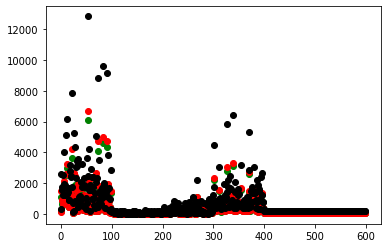

In [ ]:
plt.scatter(np.arange(600),diff_pos, color = 'green')
#plt.title('MSE with positive')
#plt.show()
plt.scatter(np.arange(600),diff_neg, color = 'red')
#plt.title('MSE with negative')
#plt.show()
plt.scatter(np.arange(600),diff, color = 'black')
#plt.title('Neg+pos (1:1)')

## Constructing function for optimization

In [49]:
import subprocess
subprocess.call(["gfortran","-o","outputic","F.f90"]) #just for compile the programm

0

In [ ]:
(pd.read_csv('./new_output.txt', sep=' ',nrows=1, header=None))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,NaN,N,=,NaN,NaN,NaN,NaN,NaN,50,success,rate=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,time=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:


def Fokker_plank_eq (x_end):
  
    # real data
    #dat2 = pd.read_csv('try_to_estim_res1.txt', sep=' ',skiprows=[0,1], header=None)
    #dat2.drop(dat2.columns[0], axis = 1, inplace = True)
    #Y_pos_real = np.array(dat2[:][1])
    #Y_neg_real = np.array(dat2[:][2])
    dat2 = pd.read_csv('try_to_estim_res1.txt', sep=' ',nrows=1, header=None)
    rate_real = float(dat2[11])
    #saving new input data
    N = 51
    t = 1
    num1 = 50000
    f = open('./new_input.txt', 'w')
    f.write(str(N-1) + '\t'+ str(t) + '\n' + str(num1)+ '\t'+ str(t) +'\t' + str(10000)+ '\t'+ str(t) + '\n' )
    x = []
    y = []
    for i in range (N-1):
          #x.append(i)
          #y.append(polynom(i, x_end)[0])
          f.write(str(i) + '\t' + str(real(np.polynomial.chebyshev.chebval(i,np.array(x_end)[0]))) + '\n')
          #print(str(real(np.polynomial.chebyshev.chebval(i,np.array(x_end)[0]))))
    #x.append(50)
    #y.append(polynom(50, x_end)[0])
    f.write (str(50) + '\t' + str(np.polynomial.chebyshev.chebval(51,np.array(x_end[0]))))
    f.close()
    print(np.array(x_end)[0])
    plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),np.array(x_end)[0]))

    #fortran programm - making new distributions
    subprocess.check_output(["./outputic"])
    #saving new output data
    dat = pd.read_csv('./new_output.txt', sep=' ',skiprows=[0,1], header=None)
    dat.drop(dat.columns[0], axis = 1, inplace = True)
    rate = float(np.array(pd.read_csv('./new_output.txt', sep=' ',nrows=1, header=None)[11]))
    #print(rate)
    #checking for some bugs in the saved new data
    #for i in range (1,dat.shape[0]):
    #    if str(dat[1][i]).find('E')==-1 and str(dat[1][i]).find('e')==-1 and str(dat[1][i]).find('-') !=-1 and str(dat[1][i]).find('nan') == -1:
    #      dat[1][i] = (str(dat[1][i]).split('-')[0]) + 'E' + '-' + (str(dat[1][i]).split('-')[1])
    #    if str(dat[1][i]).find('nan') != -1 or float(dat[1][i]) == 0 and i != 0:
    #      dat[1][i] = dat[1][i-1]
    #    if str(dat[2][i]).find('E')==-1 and str(dat[2][i]).find('e')==-1 and str(dat[2][i]).find('-') !=-1 and str(dat[2][i]).find('nan') == -1:
    #      dat[2][i] = (str(dat[2][i]).split('-')[0]) + 'E' + '-' + (str(dat[2][i]).split('-')[1])
    #    if str(dat[2][i]).find('nan') != -1 or float(dat[2][i]) == 0 and i != 0:
    #      dat[2][i] = dat[2][i-1]

    Y_pos_new = np.array(dat[1][:], dtype = float)
    Y_neg_new = np.array(dat[2][:], dtype = float)
        

    # mse for minimization
    loss_true = mse((Y_pos_new[1:]),(Y_pos_real[1:]))
    loss_false = mse((Y_neg_new[1:]),(Y_neg_real[1:]))
    loss_rate = abs(rate - rate_real)
    loss_rate *= 10**(-int(math.log((2*loss_rate)/(loss_true + loss_false),10)))
    #print(loss_rate,loss_true)
    diff_new = loss_false + loss_true + loss_rate
    return diff_new

In [ ]:
# polynomial function - inverse parametrizing 
@njit
def polynom(x, param):
  param = param.reshape(-1,1)
  return param[0] + x*param[1]+ x**2*param[2]+ x**3*param[3] + x**4*param[4] #+ x**5*param[5] + x**6*param[6] + x**7*param[7] + param[0]

## BO optimization

In [46]:
#bounds for our function

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-1e-1,1e-1)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (-1e-3,1e-3)}, #2
        {'name': 'var_3', 'type': 'continuous', 'domain': (-1e-3,1e-3)}, #3
        {'name': 'var_4', 'type': 'continuous', 'domain': (-1e-5,1e-5)}, #5
        {'name': 'var_5', 'type': 'continuous', 'domain': (-1e-6,1e-6)},
        {'name': 'var_6', 'type': 'continuous', 'domain': (-8e-9,8e-9)}] #7
        
#constraints = [{'name': 'constr_1', 'constraint': '-x[:,1] -.5 + abs(x[:,0]) - np.sqrt(1-x[:,0]**2)'},
              #{'name': 'constr_2', 'constraint': 'x[:,1] +.5 - abs(x[:,0]) - np.sqrt(1-x[:,0]**2)'}]

In [50]:
X_parametr_real

array([-9.41766262e-02, -4.40741112e-04, -6.55845314e-04, -7.86353956e-06,
        3.33306705e-07, -1.91200107e-09])

[ 9.33032290e-01 -4.21483352e-01  3.94449854e-02 -1.02763467e-03
  1.04172338e-05 -3.67279480e-08]
[-6.60731755e-01  2.66473403e-01 -2.14904804e-02  5.96191896e-04
 -6.16614533e-06  2.10104925e-08]
[ 7.64621733e-01  2.02292830e-02  2.41426229e-03 -7.69981031e-05
  7.20513873e-07 -2.17563301e-09]
[ 1.03814307e+00 -4.76409080e-01  4.16210968e-02 -1.07575488e-03
  1.09645682e-05 -3.90282541e-08]
[ 2.43388704e-01  1.05463585e-02  7.59098492e-04 -1.42044853e-06
 -1.92441905e-07  1.24976584e-09]
[ 4.99349105e-01  1.39447363e-02  1.96793532e-03 -3.56405933e-05
  1.00690757e-07  4.67428832e-10]
[ 4.01755557e-01 -1.19753764e-01  1.27952380e-02 -3.07322937e-04
  2.74216623e-06 -8.31934396e-09]
[ 2.63104857e-01  1.45337282e-02  6.62230650e-04  1.15422369e-05
 -4.07084837e-07  2.19417881e-09]
[ 2.30762029e-02  2.29160287e-02 -1.56448505e-03  8.03236232e-05
 -1.09502032e-06  4.40346240e-09]
[ 2.17998634e-01  8.93245826e-03  8.87853921e-04  6.11563234e-06
 -3.67983895e-07  2.14798736e-09]
[ 9.210172

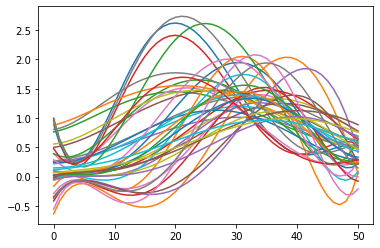

In [51]:
seed(12345)
from time import perf_counter
# BO object
import math
kernel = GPy.kern.RBF(1, 1.5, 2)
model = GPyOpt.models.GPModel(optimize_restarts=3,exact_feval = True, verbose=True) #GP model without noize and with 3 restarts
#model.model = m
t1_start = perf_counter()  
myBopt = GPyOpt.methods.BayesianOptimization(f = Fokker_plank_eq,        # function to optimize       
                                             domain = space,        # box-constraints of the problem
                                             #constraints = constraints, we have no constrains
                                             model = model,
                                             X = X_parametr_pol[:40], #возможно, легче самим добавить точки, но это мы еще посмотрим
                                             #Y = diff,
                                             #initial_design_numdata = 20, #number of initial points
                                             #initial_design_type = 'random',
                                             normalize_Y = True,
                                             verbosity = True,
                                             acquisition_type ='MPI') # acquisition = Expected improvement

t1_stop = perf_counter()
print(t1_stop - t1_start)                          

Optimization restart 1/3, f = 47.25646214982068
Optimization restart 2/3, f = 47.25646214982024
Optimization restart 3/3, f = 47.25646214981978
[-3.09888821e-02  1.00000000e-03  1.00000000e-03 -1.00000000e-05
  1.00000000e-06 -8.00000000e-09]
Optimization restart 1/3, f = 48.81661825579707
Optimization restart 2/3, f = 48.81661825579362
Optimization restart 3/3, f = 48.81661825580677
[-8.79785283e-02  1.00000000e-03 -1.00000000e-03  1.00000000e-05
 -1.00000000e-06  8.00000000e-09]
Optimization restart 1/3, f = 50.28210074698076
Optimization restart 2/3, f = 50.28210074741924
Optimization restart 3/3, f = 50.28210074698086
[ 2.35269152e-02  1.00000000e-03 -1.00000000e-03  1.00000000e-05
 -1.00000000e-06  8.00000000e-09]
Optimization restart 1/3, f = 52.44581421399225
Optimization restart 2/3, f = 52.44581421387497
Optimization restart 3/3, f = 52.44581421389559
[ 1.e-01  1.e-03  1.e-03 -1.e-05  1.e-06 -8.e-09]
Optimization restart 1/3, f = 53.692364035403585
Optimization restart 2/3, f 

ValueError: ignored

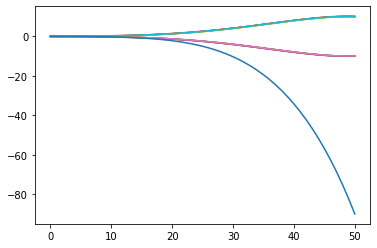

In [52]:
t1_start = perf_counter()
myBopt.run_optimization(100)
t1_stop = perf_counter()
print(t1_stop - t1_start) 

In [ ]:
#results of optimization
myBopt.x_opt

array([-2.35123178e-01,  4.51096656e-02, -4.93580995e-03,  6.57998492e-05,
       -2.25507018e-07])

In [ ]:
X_parametr_real

array([-9.41786261e-02, -8.34339227e-04, -1.31702354e-03, -1.56697191e-05,
        6.66613410e-07, -3.82400213e-09])

### MSE for (1-rate)*mse_true(,) + (rate)*mse_false

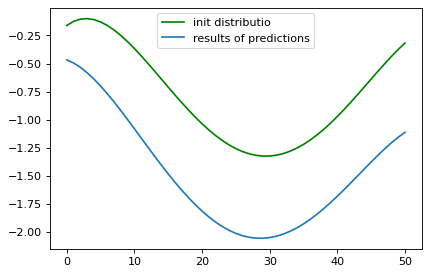

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_real), color = 'g', label = 'init distributio')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), label = 'results of predictions', )
plt.legend()

### MSE for (rate)*mse_true(,) + (1-rate)*mse_false

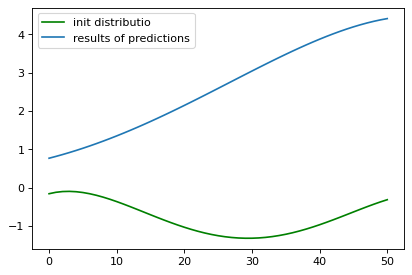

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_real), color = 'g', label = 'init distributio')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), label = 'results of predictions', )
plt.legend()

### MSE for (rate)*mse_true(log,log) + (1-rate)*mse_false

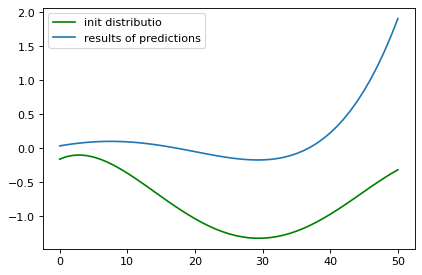

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_real), color = 'g', label = 'init distributio')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), label = 'results of predictions', )
plt.legend()

### MSE for (1-rate)*mse_true(log,log) + rate*mse_false

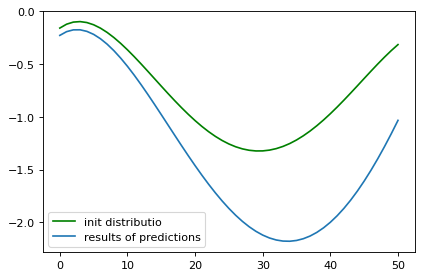

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_real), color = 'g', label = 'init distributio')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), label = 'results of predictions', )
plt.legend()

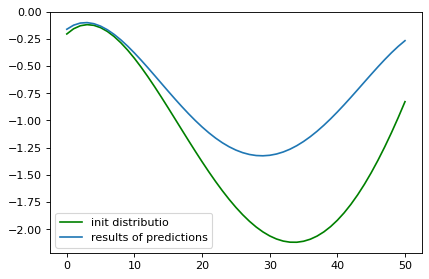

In [ ]:
plt.figure(dpi = 80)
plt.plot(distr, color = 'g', label = 'init distributio')
plt.plot(b_pred, label = 'results of predictions', )
plt.legend()